# A tour of awesome features of spaCy (part 2/2)

In [1]:
#!python -m spacy download en_vectors_web_lg

## Pretraining

In [1]:
import pandas as pd
train_df = pd.read_csv('train.csv')

In [2]:
train_df.head()

,title,mlai
0,The Road Ahead: Artificial Intelligence will a...,1
1,Can Robots Teach Us How to Be Human?,1
2,Vehicle DC Voltage Converter Step down 24V to ...,0
3,Which Is The Best Tablet For Kids?,0
4,Top 10 Strongest Dog Breeds in the World,0


In [3]:
# no need to run this, texts.jsonl is already available 
import jsonlines 
with jsonlines.open('texts.jsonl', mode='w') as writer:
    for text in train_df.title:
        writer.write({'text':text})

In [4]:
# word count
count = 0
for title in train_df.title:
    count += len(title.split())

print(count)

125517


In [5]:
!python -m spacy pretrain -h

usage: spacy pretrain [-h] [-cw 96] [-cd 4] [-er 2000] [-L cosine] [-uv]
                      [-d 0.2] [-i 1000] [-bs 3000] [-xw 500] [-nw 5] [-s 0]
                      texts_loc vectors_model output_dir

    Pre-train the 'token-to-vector' (tok2vec) layer of pipeline components,
    using an approximate language-modelling objective. Specifically, we load
    pre-trained vectors, and train a component like a CNN, BiLSTM, etc to predict
    vectors which match the pre-trained ones. The weights are saved to a directory
    after each epoch. You can then pass a path to one of these pre-trained weights
    files to the 'spacy train' command.

    This technique may be especially helpful if you have little labelled data.
    However, it's still quite experimental, so your mileage may vary.

    To load the weights back in during 'spacy train', you need to ensure
    all settings are the same between pretraining and training. The API and
    errors around this need some improvement.
    


In [6]:
#!python -m spacy pretrain texts.jsonl en_vectors_web_lg ./pretrained-model
#!python -m spacy pretrain texts.jsonl en_vectors_web_lg ./pretrained-model-vecs --use-vectors

## Training 

In [7]:
# preprocess trian data
train_texts = train_df['title']
train_cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} 
                 for y in train_df['mlai']]

# load and preprocess dev data
dev_df = pd.read_csv('dev.csv')
dev_texts = dev_df['title']
dev_cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} 
                 for y in dev_df['mlai']]

train_data = list(zip(train_texts, [{"cats": cats} 
                                     for cats in train_cats]))

In [8]:
train_data[0]

('The Road Ahead: Artificial Intelligence will assist in regulatory compliance',
 {'cats': {'POSITIVE': True, 'NEGATIVE': False}})

In [9]:
print(len(train_texts))
print(len(dev_texts))

15896
7937


In [10]:
# this code is modified from spaCy's user guide for TextCategorizer training 
import random
from pathlib import Path
import numpy as np

import spacy
from spacy.util import minibatch, compounding

def main(model=None, n_iter=5, init_tok2vec=None):
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")

    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "textcat" not in nlp.pipe_names:
        textcat = nlp.create_pipe(
            "textcat",
            config={
                "exclusive_classes": True,
                "architecture": "simple_cnn",
            }
        )
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe("textcat")

    # add label to text classifier
    textcat.add_label("POSITIVE")
    textcat.add_label("NEGATIVE")

    # load the datasets
    print("Loading data...")
    train_df = pd.read_csv('train.csv')
    train_texts = train_df['title']
    train_cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} 
                     for y in train_df['mlai']]

    dev_df = pd.read_csv('dev.csv')
    dev_texts = dev_df['title']
    dev_cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} 
                     for y in dev_df['mlai']]

    print(
        "Using {} examples ({} training, {} evaluation)".format(
            len(train_texts) + len(dev_texts), len(train_texts), len(dev_texts)
        )
    )
    train_data = list(zip(train_texts, [{"cats": cats} for cats in train_cats]))
        
    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]
    results_df = pd.DataFrame(np.nan, index=range(n_iter), columns=['loss', 'accuracy', 'precision', 'recall', 'f1'])
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        if init_tok2vec is not None:
            init_tok2vec = Path(init_tok2vec)
            with init_tok2vec.open("rb") as file_:
                textcat.model.tok2vec.from_bytes(file_.read())
        print("Training the model...")
        print("{:^5}\t{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "A", "P", "R", "F"))
        batch_sizes = compounding(4.0, 32.0, 1.001)
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            random.shuffle(train_data)
            batches = minibatch(train_data, size=batch_sizes)
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            results_df.loc[i,'loss'] = losses["textcat"]
            results_df.loc[i,'accuracy'] = scores["textcat_a"]
            results_df.loc[i,'precision'] = scores["textcat_p"]
            results_df.loc[i,'recall'] = scores["textcat_r"]
            results_df.loc[i,'f1'] = scores["textcat_f"]
            print(
                "{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t{4:.3f}".format(  # print a simple table
                    losses["textcat"],
                    scores["textcat_a"],
                    scores["textcat_p"],
                    scores["textcat_r"],
                    scores["textcat_f"],
                )
            )
    return results_df        
                

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fn + fp)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_a": accuracy, "textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}

In [11]:
spacy.util.fix_random_seed(1)
mp1000 = main(model='en_core_web_lg', init_tok2vec='pretrained-model-lg-tags/model999.bin')

Loaded model 'en_core_web_lg'
Loading data...
Using 23833 examples (15896 training, 7937 evaluation)
Training the model...
LOSS 	  A  	  P  	  R  	  F  
6.318	0.890	0.871	0.928	0.899
0.061	0.885	0.875	0.911	0.893
0.023	0.882	0.872	0.910	0.891
0.017	0.883	0.872	0.911	0.891
0.014	0.880	0.869	0.908	0.888


In [12]:
mb = main(model='en_core_web_lg', init_tok2vec=None)

Loaded model 'en_core_web_lg'
Loading data...
Using 23833 examples (15896 training, 7937 evaluation)
Training the model...
LOSS 	  A  	  P  	  R  	  F  
8.120	0.879	0.872	0.902	0.887
0.072	0.877	0.866	0.907	0.886
0.027	0.874	0.865	0.900	0.882
0.022	0.869	0.862	0.893	0.877
0.019	0.868	0.862	0.893	0.877


In [13]:
bp1000 = main(model=None, init_tok2vec='pretrained-model-tags/model999.bin')

Created blank 'en' model
Loading data...
Using 23833 examples (15896 training, 7937 evaluation)
Training the model...
LOSS 	  A  	  P  	  R  	  F  
6.810	0.873	0.866	0.897	0.882
0.066	0.868	0.864	0.890	0.877
0.025	0.868	0.862	0.892	0.877
0.019	0.869	0.862	0.895	0.878
0.016	0.867	0.860	0.892	0.876


In [14]:
bb = main(model=None, init_tok2vec=None)

Created blank 'en' model
Loading data...
Using 23833 examples (15896 training, 7937 evaluation)
Training the model...
LOSS 	  A  	  P  	  R  	  F  
9.957	0.850	0.832	0.894	0.862
0.085	0.854	0.849	0.878	0.863
0.032	0.853	0.850	0.875	0.863
0.025	0.851	0.849	0.870	0.860
0.020	0.846	0.845	0.866	0.855


In [15]:
mp50 = main(model='en_core_web_lg', init_tok2vec='pretrained-model-lg-tags/model49.bin')

Loaded model 'en_core_web_lg'
Loading data...
Using 23833 examples (15896 training, 7937 evaluation)
Training the model...
LOSS 	  A  	  P  	  R  	  F  
6.943	0.882	0.870	0.913	0.891
0.067	0.879	0.869	0.906	0.887
0.026	0.873	0.865	0.898	0.881
0.020	0.871	0.863	0.897	0.880
0.016	0.869	0.860	0.896	0.878


In [16]:
bp50 = main(model=None, init_tok2vec='pretrained-model-tags/model49.bin')

Created blank 'en' model
Loading data...
Using 23833 examples (15896 training, 7937 evaluation)
Training the model...
LOSS 	  A  	  P  	  R  	  F  
8.137	0.863	0.853	0.894	0.873
0.076	0.861	0.856	0.884	0.870
0.030	0.858	0.856	0.877	0.866
0.024	0.855	0.855	0.873	0.864
0.017	0.859	0.854	0.882	0.868


In [17]:
mp1000['model'] = 'Large Model'
mp1000['pretraining'] = '1000'
mp50['model'] = 'Large Model'
mp50['pretraining'] = '50'
mb['model'] = 'Large Model'
mb['pretraining'] = '0'
bp1000['model'] = 'Blank Model'
bp1000['pretraining'] = '1000'
bp50['model'] = 'Blank Model'
bp50['pretraining'] = '50'
bb['model'] = 'Blank Model'
bb['pretraining'] = '0'

In [18]:
df = pd.concat([mp1000, mp50, mb, bp1000, bp50, bb])
df['n_iter'] = df.index + 1

In [19]:
df.head(10)

,loss,accuracy,precision,recall,f1,model,pretraining,n_iter
0,6.317707,0.890135,0.871316,0.928109,0.898816,Large Model,1000,1
1,0.060880,0.884717,0.875000,0.910855,0.892568,Large Model,1000,2
2,0.022972,0.882449,0.872243,0.909657,0.890557,Large Model,1000,3
3,0.017460,0.882953,0.872189,0.910855,0.891103,Large Model,1000,4
4,0.014031,0.879929,0.869436,0.907980,0.888290,Large Model,1000,5
0,6.943340,0.882449,0.870201,0.912533,0.890864,Large Model,50,1
1,0.066511,0.878544,0.868766,0.905823,0.886908,Large Model,50,2
2,0.025983,0.872622,0.864622,0.898394,0.881185,Large Model,50,3
3,0.020264,0.870984,0.862704,0.897436,0.879728,Large Model,50,4
4,0.016461,0.868716,0.860133,0.895998,0.877700,Large Model,50,5


In [39]:
#df.to_csv('scores.csv')
#df = pd.read_csv('scores.csv')
df.pretraining = df.pretraining.astype('category', categories=['0', '50', '1000'])

In [20]:
from plotnine import *
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

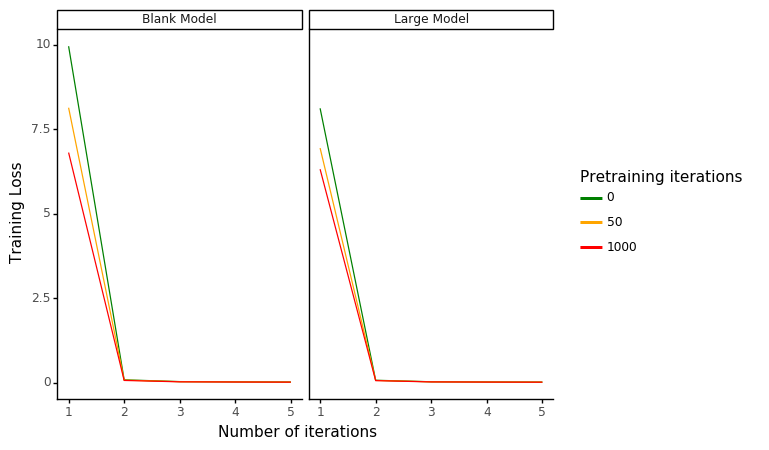

<ggplot: (-9223372036544678873)>

In [40]:
color_dict = {'0': 'green', 
              '50':'orange',
              '1000':'red'}

(ggplot(df, aes('n_iter', 'loss', color='pretraining'))
 + geom_line()
 + facet_wrap('~model')
 + labs(x='Number of iterations', y='Training Loss', color='Pretraining iterations')
 + scale_color_manual(values=color_dict)
 + theme_classic()
 )

#p.save(filename = '../loss.png', height=5, width=5, units = 'in', dpi=500)

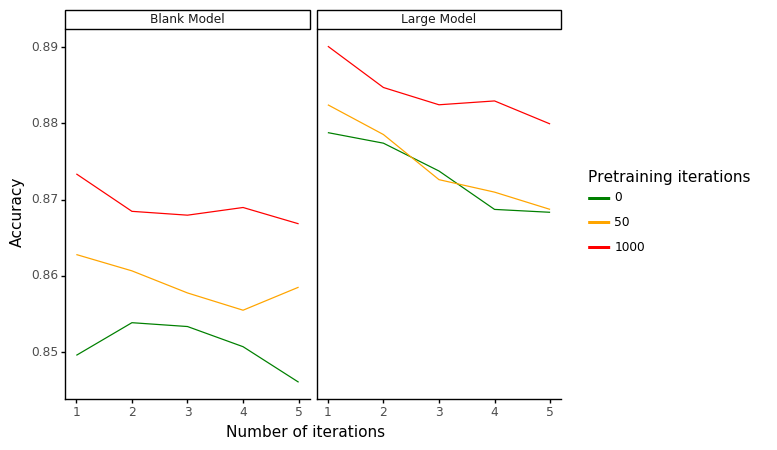

<ggplot: (309822973)>

In [41]:
(ggplot(df, aes('n_iter', 'accuracy', color='pretraining'))
 + geom_line()
 + facet_wrap('~model')
 + labs(x='Number of iterations', y='Accuracy', color='Pretraining iterations')
 + scale_color_manual(values=color_dict)
 + theme_classic()
 )

#p.save(filename = '../acc.png', height=5, width=5, units = 'in', dpi=500)

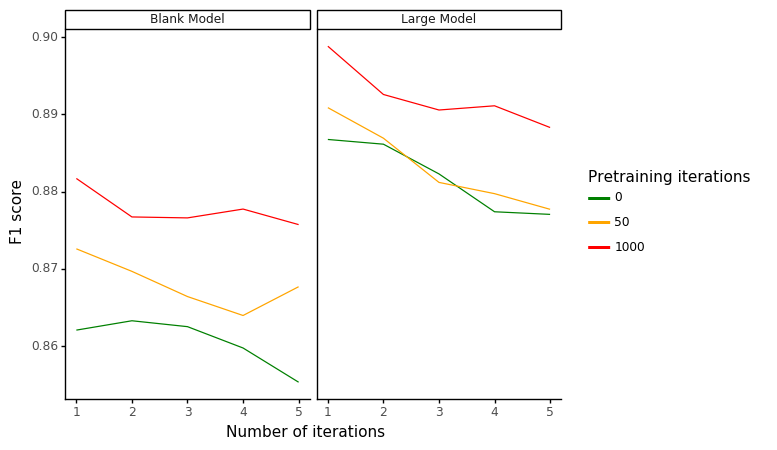

<ggplot: (-9223372036545874386)>

In [42]:
(ggplot(df, aes('n_iter', 'f1', color='pretraining'))
 + geom_line()
 + facet_wrap('~model')
 + labs(x='Number of iterations', y='F1 score', color='Pretraining iterations')
 + scale_color_manual(values=color_dict)
 + theme_classic()
 )

#p.save(filename = '../f1.png', height=5, width=5, units = 'in', dpi=500)